In [66]:
import os
import hashlib
import requests
import zipfile, tarfile
import numpy as np
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

def download():
    url, sha1_hash = ('http://d2l-data.s3-accelerate.amazonaws.com/ctr.zip',
                        'e18327c48c8e8e5c23da714dd614e390d369843f')
    cache_dir=os.path.join('..', 'data')
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(folder=None):
    fname = download()
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


In [67]:
class CTRDataset(Dataset):
    '''
    return features(34개), target(0 or 1)
    '''
    def __init__(self, data_path, feat_mapper=None, defaults=None,
                 min_threshold=4, num_feat=34):
        self.NUM_FEATS, self.count, self.data = num_feat, 0, {}
        feat_cnts = defaultdict(lambda: defaultdict(int))
        self.feat_mapper, self.defaults = feat_mapper, defaults
        self.field_dims = np.zeros(self.NUM_FEATS, dtype=np.int64)
        with open(data_path) as f:
            for line in f:
                instance = {}
                values = line.rstrip('\n').split('\t')
                if len(values) != self.NUM_FEATS + 1:
                    continue
                label = np.float32([0, 0])
                label[int(values[0])] = 1
                instance['y'] = [np.float32(values[0])]
                for i in range(1, self.NUM_FEATS + 1):
                    feat_cnts[i][values[i]] += 1
                    instance.setdefault('x', []).append(values[i])
                self.data[self.count] = instance
                self.count = self.count + 1
        if self.feat_mapper is None and self.defaults is None:
            feat_mapper = {i: {feat for feat, c in cnt.items() if c >=
                               min_threshold} for i, cnt in feat_cnts.items()}
            self.feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                                for i, feat_values in feat_mapper.items()}
            self.defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
        for i, fm in self.feat_mapper.items():
            self.field_dims[i - 1] = len(fm) + 1
        self.offsets = np.array((0, *np.asarray(np.cumsum(self.field_dims))
                                 [:-1]))

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        feat = np.array([self.feat_mapper[i + 1].get(v, self.defaults[i + 1])
                         for i, v in enumerate(self.data[idx]['x'])])
        return feat + self.offsets, self.data[idx]['y']

In [68]:
class DeepFM(nn.Module):
    '''
    input: features
    output : 0~1사이의 실수
    '''
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        self.num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(self.num_inputs, num_factors)
        self.fc = nn.Embedding(self.num_inputs, 1)
        self.linear_layer = nn.Linear(1, 1)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = []
        for dim in mlp_dims:
            self.mlp.append(nn.Linear(input_dim, dim))
            self.mlp.append(nn.ReLU())
            self.mlp.append(nn.Dropout(p=drop_rate))
            input_dim = dim
        self.mlp.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*self.mlp)

    def forward(self, x):
        # x : (batch_size, feature개수)
        embed_x = self.embedding(x) # embed_x : (batch_size, feature개수, num_factors)
        square_of_sum = torch.sum(embed_x, axis=1) ** 2 # (batch_size, num_factors)
        sum_of_square = torch.sum(embed_x ** 2, axis=1) # (batch_size, num_factors)
        inputs = embed_x.view(-1, self.embed_output_dim) # (batch_size, feature개수*num_factors)
        # fc(x) : (batch_size, feature개수, 1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = torch.sigmoid(x)
        return x

In [69]:
batch_size = 2048
data_dir = download_extract()
train_data = CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = DataLoader(train_data, shuffle=True, batch_size = batch_size)
test_iter = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = DeepFM(train_data.field_dims, num_factors=20, mlp_dims=[30, 20, 10])
net.to(device)
lr, num_epochs, wd = 0.002, 50, 1e-5
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=wd)

In [71]:
from tqdm import tqdm
import glob

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
  train_iter_loss = []
  for i, values in enumerate(train_iter):
    train_data = values[0].long().to(device)
    labels = values[1][0].long().to(device).unsqueeze(1) 
    preds = net(train_data) #.squeeze()
    loss = loss_func(preds.to(torch.float32), labels.to(torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_iter_loss.append(loss.detach().item())
    if i%50 == 0:
      print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
  train_epoch_loss.append(np.mean(train_iter_loss))
  print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))
  
  with torch.no_grad():
    net.eval()
    val_epoch_loss = 0
    for i, values in enumerate(test_iter):
      test_data = values[0].long().to(device)
      labels = values[1][0].long().to(device).unsqueeze(1) 
      preds = net(test_data)
      loss = loss_func(preds.to(torch.float32), labels.to(torch.float32))
      val_epoch_loss += loss.detach().item()
  val_epoch_loss /= len(test_iter)
  val_epoch_loss_lst.append(val_epoch_loss)

  if val_epoch_loss < best_val_epoch_loss:
    best_val_epoch_loss = val_epoch_loss
    print(f'New best model loss: {best_val_epoch_loss}')
    if not os.path.exists('model'):
      os.mkdir('model')

    if os.path.exists('model/best.pth'):
      os.remove('model/best.pth')
    torch.save(net.state_dict(), 'model/best.pth')
    print('best model is saved!')
    
  

  0%|          | 0/50 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 36.178558349609375


  2%|▏         | 1/50 [00:00<00:27,  1.78it/s]

0 epoch ALL LOSS :  33.179922103881836
New best model loss: 31.098617553710938
best model is saved!
1 epoch 0th train iter loss: 30.685134887695312


  4%|▍         | 2/50 [00:01<00:30,  1.58it/s]

1 epoch ALL LOSS :  29.566009521484375
New best model loss: 28.942891120910645
best model is saved!
2 epoch 0th train iter loss: 27.866302490234375


  6%|▌         | 3/50 [00:01<00:26,  1.76it/s]

2 epoch ALL LOSS :  28.035428762435913
3 epoch 0th train iter loss: 30.201126098632812


  8%|▊         | 4/50 [00:02<00:23,  1.94it/s]

3 epoch ALL LOSS :  30.86069941520691
4 epoch 0th train iter loss: 33.5452995300293


 10%|█         | 5/50 [00:02<00:22,  2.02it/s]

4 epoch ALL LOSS :  34.63288736343384
5 epoch 0th train iter loss: 35.245506286621094


 12%|█▏        | 6/50 [00:03<00:23,  1.87it/s]

5 epoch ALL LOSS :  34.36894130706787
6 epoch 0th train iter loss: 33.14396667480469


 14%|█▍        | 7/50 [00:03<00:23,  1.86it/s]

6 epoch ALL LOSS :  30.78792929649353
7 epoch 0th train iter loss: 30.035152435302734


 16%|█▌        | 8/50 [00:04<00:21,  1.96it/s]

7 epoch ALL LOSS :  28.13148546218872
New best model loss: 28.29836654663086
best model is saved!
8 epoch 0th train iter loss: 26.906681060791016


 18%|█▊        | 9/50 [00:04<00:20,  2.04it/s]

8 epoch ALL LOSS :  26.774973392486572
New best model loss: 27.582341194152832
best model is saved!
9 epoch 0th train iter loss: 27.063289642333984


 20%|██        | 10/50 [00:05<00:20,  1.97it/s]

9 epoch ALL LOSS :  25.628714323043823
New best model loss: 25.56212329864502
best model is saved!
10 epoch 0th train iter loss: 25.920005798339844


 22%|██▏       | 11/50 [00:05<00:19,  2.03it/s]

10 epoch ALL LOSS :  24.19714665412903
New best model loss: 24.168317794799805
best model is saved!
11 epoch 0th train iter loss: 23.309066772460938


 24%|██▍       | 12/50 [00:06<00:18,  2.01it/s]

11 epoch ALL LOSS :  22.473506689071655
New best model loss: 22.69062614440918
best model is saved!
12 epoch 0th train iter loss: 21.257728576660156


 26%|██▌       | 13/50 [00:06<00:18,  2.03it/s]

12 epoch ALL LOSS :  20.828601598739624
New best model loss: 21.165526390075684
best model is saved!
13 epoch 0th train iter loss: 22.14474105834961


 28%|██▊       | 14/50 [00:07<00:17,  2.01it/s]

13 epoch ALL LOSS :  19.959519624710083
New best model loss: 18.9201078414917
best model is saved!
14 epoch 0th train iter loss: 18.499483108520508


 30%|███       | 15/50 [00:07<00:16,  2.09it/s]

14 epoch ALL LOSS :  17.692288160324097
New best model loss: 18.567873001098633
best model is saved!
15 epoch 0th train iter loss: 16.759979248046875


 32%|███▏      | 16/50 [00:08<00:15,  2.15it/s]

15 epoch ALL LOSS :  16.53711247444153
New best model loss: 15.354359149932861
best model is saved!
16 epoch 0th train iter loss: 14.014077186584473


 34%|███▍      | 17/50 [00:08<00:16,  2.06it/s]

16 epoch ALL LOSS :  14.603336334228516
New best model loss: 14.739954471588135
best model is saved!
17 epoch 0th train iter loss: 13.832149505615234


 36%|███▌      | 18/50 [00:09<00:16,  1.94it/s]

17 epoch ALL LOSS :  12.755188703536987
New best model loss: 13.501718044281006
best model is saved!
18 epoch 0th train iter loss: 12.471742630004883


 38%|███▊      | 19/50 [00:09<00:15,  1.95it/s]

18 epoch ALL LOSS :  11.218371272087097
New best model loss: 11.678932666778564
best model is saved!
19 epoch 0th train iter loss: 11.583291053771973


 40%|████      | 20/50 [00:10<00:15,  2.00it/s]

19 epoch ALL LOSS :  10.059635400772095
New best model loss: 9.834943771362305
best model is saved!
20 epoch 0th train iter loss: 9.517034530639648


 42%|████▏     | 21/50 [00:10<00:14,  2.06it/s]

20 epoch ALL LOSS :  8.712059617042542
New best model loss: 8.75645637512207
best model is saved!
21 epoch 0th train iter loss: 9.52261734008789


 44%|████▍     | 22/50 [00:11<00:13,  2.01it/s]

21 epoch ALL LOSS :  8.039449870586395
New best model loss: 7.998049736022949
best model is saved!
22 epoch 0th train iter loss: 8.02458381652832


 46%|████▌     | 23/50 [00:11<00:13,  2.06it/s]

22 epoch ALL LOSS :  7.406175673007965
New best model loss: 7.456748962402344
best model is saved!
23 epoch 0th train iter loss: 6.549163818359375


 48%|████▊     | 24/50 [00:12<00:12,  2.04it/s]

23 epoch ALL LOSS :  6.965938150882721
24 epoch 0th train iter loss: 5.865653038024902


 50%|█████     | 25/50 [00:12<00:11,  2.12it/s]

24 epoch ALL LOSS :  6.572366416454315
25 epoch 0th train iter loss: 6.4071364402771


 52%|█████▏    | 26/50 [00:13<00:12,  1.98it/s]

25 epoch ALL LOSS :  6.329586386680603
New best model loss: 7.337900876998901
best model is saved!
26 epoch 0th train iter loss: 5.996511936187744


 54%|█████▍    | 27/50 [00:13<00:11,  2.06it/s]

26 epoch ALL LOSS :  6.0260873436927795
New best model loss: 7.273409605026245
best model is saved!
27 epoch 0th train iter loss: 5.564242362976074


 56%|█████▌    | 28/50 [00:13<00:10,  2.12it/s]

27 epoch ALL LOSS :  5.7509108781814575
New best model loss: 6.033326864242554
best model is saved!
28 epoch 0th train iter loss: 5.329197883605957


 58%|█████▊    | 29/50 [00:14<00:09,  2.10it/s]

28 epoch ALL LOSS :  5.558054506778717
29 epoch 0th train iter loss: 5.998775482177734


 60%|██████    | 30/50 [00:15<00:10,  1.94it/s]

29 epoch ALL LOSS :  5.590436041355133
30 epoch 0th train iter loss: 5.654323577880859


 62%|██████▏   | 31/50 [00:15<00:09,  1.98it/s]

30 epoch ALL LOSS :  5.271428167819977
31 epoch 0th train iter loss: 5.347706317901611


 64%|██████▍   | 32/50 [00:16<00:08,  2.04it/s]

31 epoch ALL LOSS :  5.159383326768875
New best model loss: 5.632858037948608
best model is saved!
32 epoch 0th train iter loss: 4.760558605194092


 66%|██████▌   | 33/50 [00:16<00:08,  2.11it/s]

32 epoch ALL LOSS :  5.041462302207947
33 epoch 0th train iter loss: 5.8557868003845215


 68%|██████▊   | 34/50 [00:17<00:08,  1.97it/s]

33 epoch ALL LOSS :  4.89450216293335
New best model loss: 5.507040977478027
best model is saved!
34 epoch 0th train iter loss: 4.7032341957092285


 70%|███████   | 35/50 [00:17<00:07,  2.02it/s]

34 epoch ALL LOSS :  4.862931489944458
New best model loss: 5.232589960098267
best model is saved!
35 epoch 0th train iter loss: 4.526340007781982


 72%|███████▏  | 36/50 [00:17<00:06,  2.12it/s]

35 epoch ALL LOSS :  4.705888599157333
36 epoch 0th train iter loss: 3.9754576683044434


 74%|███████▍  | 37/50 [00:18<00:06,  2.14it/s]

36 epoch ALL LOSS :  4.802409112453461
37 epoch 0th train iter loss: 5.205889701843262


 76%|███████▌  | 38/50 [00:18<00:05,  2.05it/s]

37 epoch ALL LOSS :  4.8168588280677795
38 epoch 0th train iter loss: 4.598916530609131


 78%|███████▊  | 39/50 [00:19<00:05,  1.99it/s]

38 epoch ALL LOSS :  4.725350111722946
39 epoch 0th train iter loss: 4.142823696136475


 80%|████████  | 40/50 [00:19<00:04,  2.01it/s]

39 epoch ALL LOSS :  4.692889988422394
40 epoch 0th train iter loss: 4.67658805847168


 82%|████████▏ | 41/50 [00:20<00:04,  2.07it/s]

40 epoch ALL LOSS :  4.576003074645996
41 epoch 0th train iter loss: 4.589204788208008


 84%|████████▍ | 42/50 [00:20<00:03,  2.02it/s]

41 epoch ALL LOSS :  4.579861879348755
42 epoch 0th train iter loss: 4.671661853790283


 86%|████████▌ | 43/50 [00:21<00:03,  2.07it/s]

42 epoch ALL LOSS :  4.590117573738098
43 epoch 0th train iter loss: 4.568737983703613


 88%|████████▊ | 44/50 [00:21<00:02,  2.05it/s]

43 epoch ALL LOSS :  4.497128903865814
New best model loss: 5.177521467208862
best model is saved!
44 epoch 0th train iter loss: 3.92897891998291


 90%|█████████ | 45/50 [00:22<00:02,  1.93it/s]

44 epoch ALL LOSS :  4.492255091667175
45 epoch 0th train iter loss: 4.317757606506348


 92%|█████████▏| 46/50 [00:22<00:02,  1.92it/s]

45 epoch ALL LOSS :  4.4998942613601685
46 epoch 0th train iter loss: 4.42375373840332


 94%|█████████▍| 47/50 [00:23<00:01,  1.89it/s]

46 epoch ALL LOSS :  4.520755290985107
47 epoch 0th train iter loss: 4.530608177185059


 96%|█████████▌| 48/50 [00:23<00:01,  1.96it/s]

47 epoch ALL LOSS :  4.478893339633942
48 epoch 0th train iter loss: 4.601321220397949


 98%|█████████▊| 49/50 [00:24<00:00,  1.92it/s]

48 epoch ALL LOSS :  4.523911476135254
49 epoch 0th train iter loss: 4.005146026611328


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]

49 epoch ALL LOSS :  4.352090626955032


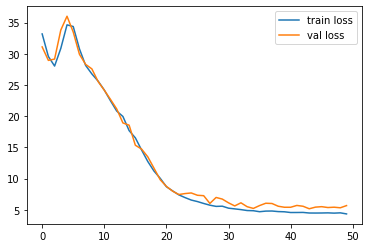

In [72]:
import matplotlib.pyplot as plt

plt.plot(train_epoch_loss, label='train loss')
plt.plot(val_epoch_loss_lst, label='val loss')
plt.legend()